In [1]:
!pip install torch torchvision
!pip install matplotlib pillow
!pip install diffusers transformers
!pip install huggingface_hub
from torchvision import transforms, models


In [2]:
from diffusers import StableDiffusionPipeline
import torch

# Load the correct model (no need for "-original")
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

# Use CPU or GPU depending on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

/opt/anaconda3/envs/stablemix/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 20.48it/s]


In [3]:
prompt = "Create a pink flower in the garden"
image = pipe(prompt).images[0]
image.show()

100%|██████████| 50/50 [04:54<00:00,  5.89s/it]


In [4]:
image.save("new_flower.png")


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
loader = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(image_path, max_size=512, shape=None, normalize=True):
    image = Image.open(image_path).convert('RGB')
    
    # Resize
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = in_transform(image).unsqueeze(0)
    return image.to(device)

def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    image = torch.clamp(image, 0, 1)
    plt.imshow(image.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.show()

In [8]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

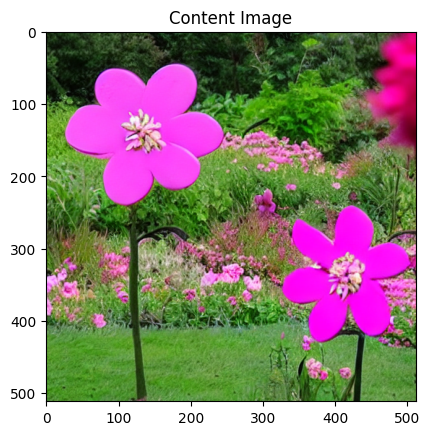

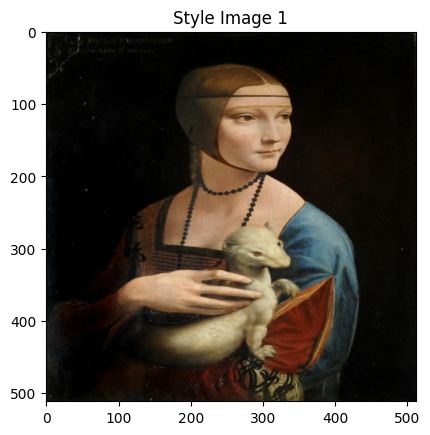

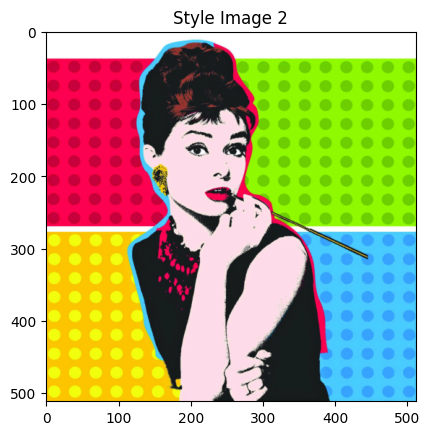

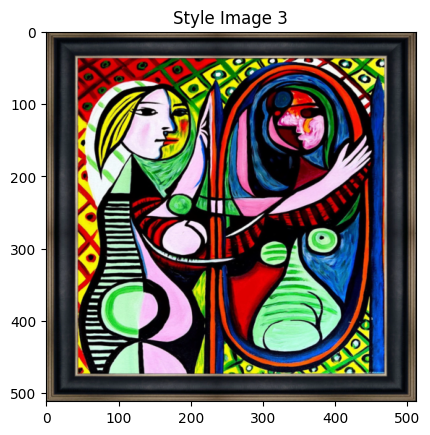

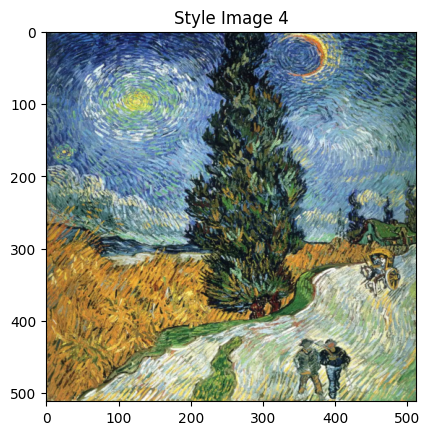

In [9]:
content_img = load_image("new_flower.png")
styles = ["leonardo.png", "andy.png", "picasso.png", "van gogh.png"]
style_imgs = [load_image(path) for path in styles]
imshow(content_img, title='Content Image')
for i, img in enumerate(style_imgs):
    imshow(img, title=f"Style Image {i+1}")

In [11]:
import torch.nn as nn

In [13]:
def gram_matrix(tensor):
    # Get batch_size, depth, height, width
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [14]:
# Load the pretrained VGG-19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze the model's weights
for param in vgg.parameters():
    param.requires_grad = False

# Define which layers to extract features from
# These are layer names as found in torchvision's VGG19
content_layers = ['conv_4']  # One layer for content
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']  # Multiple for style

# Helper to name layers
def get_features(image, model, layers=None):
    features = {}
    x = image
    i = 0
    for layer in model.children():
        x = layer(x)
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
            if layers is None or name in layers:
                features[name] = x
    return features

# Extract features
content_features = get_features(content_img, vgg, content_layers)

# Initialize a dictionary to hold the combined gram matrices
style_grams_combined = {}

# Initialize the layers with zero
for layer in style_layers:
    style_grams_combined[layer] = 0

# Loop through all style images and accumulate gram matrices
for style_img in style_imgs:
    features = get_features(style_img, vgg, style_layers)
    for layer in style_layers:
        gram = gram_matrix(features[layer])
        style_grams_combined[layer] += gram

# Average gram matrices across all styles
for layer in style_layers:
    style_grams_combined[layer] /= len(style_imgs)

In [15]:
def run_style_transfer(content_img, content_features, style_grams, vgg, 
                       content_weight=1e4, style_weight=1e2, num_steps=500):

    # Initialize the target image as a clone of the content image
    target = content_img.clone().requires_grad_(True).to(device)

    # Use Adam optimizer to update target pixels
    optimizer = torch.optim.Adam([target], lr=0.003)

    for step in range(1, num_steps + 1):
        # Get features of the target image
        target_features = get_features(target, vgg, style_layers + content_layers)

        # --- Content Loss ---
        content_loss = torch.mean((target_features['conv_4'] - content_features['conv_4']) ** 2)

        # --- Style Loss ---
        style_loss = 0
        for layer in style_layers:
            target_gram = gram_matrix(target_features[layer])
            style_gram = style_grams[layer]
            _, d, h, w = target_features[layer].shape
            style_loss += torch.mean((target_gram - style_gram) ** 2) / (d * h * w)

        # --- Total Loss ---
        total_loss = content_weight * content_loss + style_weight * style_loss

        # Backprop and update image
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print progress
        if step % 50 == 0:
            print(f"Step {step}, Total loss: {total_loss.item():.2f}")

    return target

In [16]:
output = run_style_transfer(content_img, content_features, style_grams_combined, vgg)


Step 50, Total loss: 3257335.75
Step 100, Total loss: 2130356.50
Step 150, Total loss: 1455347.25
Step 200, Total loss: 1029133.56
Step 250, Total loss: 750351.25
Step 300, Total loss: 563016.44
Step 350, Total loss: 434144.69
Step 400, Total loss: 343525.16
Step 450, Total loss: 278489.72
Step 500, Total loss: 231049.75


In [17]:
def unnormalize(image):
    # VGG normalization: mean and std values used during training
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image * std + mean  # Unnormalize
    return image

In [18]:
import matplotlib.pyplot as plt

def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach()  # Detach from the computation graph
    image = image.squeeze(0)  # Remove batch dimension
    image = unnormalize(image)  # Unnormalize the image if needed
    image = torch.clamp(image, 0, 1)  # Ensure the pixel values are between 0 and 1

    # Convert the tensor to a format compatible with plt.imshow()
    plt.imshow(image.permute(1, 2, 0).numpy())  # Convert to NumPy array
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

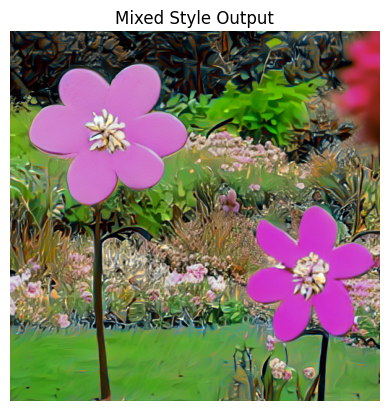

In [19]:
imshow(output, title="Mixed Style Output")